In [1]:
import random
import torch
import scvi
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


## Data processing (skip)

Dataset curation at https://github.com/theislab/sc-pert/blob/main/datasets/Norman_2019.ipynb

In [2]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/sc-pert/datasets/Norman_2019.h5ad')
adata

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/guide_identity' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/guide_identity' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/read_count' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/guide_PRTG' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/guide_PTPN1' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/guide_PTPN12' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/guide_PTPN13' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_pca' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/X_umap' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsp' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' wa

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

TODO: add Schraivogel if things work out.

Subset to singletons to simplify the problem without much data loss.

In [3]:
adata = adata[adata.obs.perturbation_name.isin(
    [x for x in adata.obs.perturbation_name.value_counts().index if '+' not in x])]
adata.shape

(69570, 19018)

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))


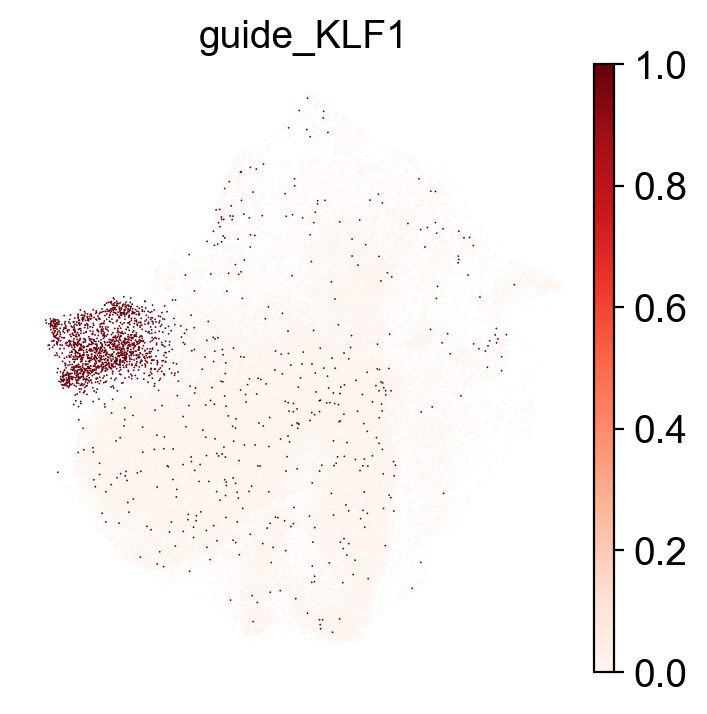

In [4]:
sc.pl.umap(adata, color=['guide_KLF1'], cmap='Reds')

In [5]:
sound_labels = adata.obs.perturbation_name.value_counts()[adata.obs.perturbation_name.value_counts() > 100].index
adata = adata[adata.obs.perturbation_name.isin(sound_labels)].copy()
len(sound_labels)

106

Now let's look at the guides with no overlap with var_names. Since we can't use these samples for feature attribution, we'll use a portion of them as a test set.

In [6]:
missing_var = set(sound_labels) - set(adata.var_names) - set(['control'])
missing_var

{'C19orf26', 'C3orf72', 'KIAA1804'}

In [7]:
test_indices = random.sample(set(adata[adata.obs.perturbation_name.isin(missing_var)].obs.index), 400)
adata.obs['split'] = 'train'
adata.obs['split'][test_indices] = 'test'
adata.obs['split'] = adata.obs['split'].astype('category')

/tmp/ipykernel_17681/3446060939.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_indices = random.sample(set(adata[adata.obs.perturbation_name.isin(missing_var)].obs.index), 400)
/tmp/ipykernel_17681/3446060939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['split'][test_indices] = 'test'
/tmp/ipykernel_17681/3446060939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['split'][test_indices] = 'test'


Take highly variable genes as recommended by scGen.

In [8]:
sc.pp.highly_variable_genes(adata)

We also want to keep the genes which correspond to the sgRNAs for downstream analysis.

In [9]:
hvgs = list(adata.var_names[adata.var['highly_variable']])
print(len(hvgs))
included_genes = hvgs + list(set(sound_labels) & set(adata.var_names))
print(len(included_genes))
adata = adata[:, included_genes].copy()

817
919


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
adata.write('../datasets/2301_scgen_norman19.h5ad')

## Train

In [28]:
adata = sc.read('../datasets/2301_scgen_norman19.h5ad')

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/guide_identity' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/guide_identity' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/read_count' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/

In [31]:
import scgen

In [32]:
# example: scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')

In [35]:
# instantiate a model to get a preview
model = scgen.SCGEN(adata, n_hidden=400, n_latent=30)
model.module

SCGENVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=919, out_features=400, bias=True)
          (1): BatchNorm1d(400, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=400, out_features=400, bias=True)
          (1): BatchNorm1d(400, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=400, out_features=30, bias=True)
    (var_encoder): Linear(in_features=400, out_features=30, bias=True)
  )
  (decoder): DecoderSCGEN(
    (decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
 

Parameters were mostly from the scGen tutorial, but the latent space was decreased in size to facilitate better downstream analysis. The two training runs so far are:

- (no suffix) no modifications, no HVGs
- (v2) HVGS, n_hidden=400, n_latent=30

In [36]:
torch.cuda.is_available()

True

Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old an

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [09:10<26:07, 21.19s/it, loss=41.9, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 293.004. Signaling Trainer to stop.


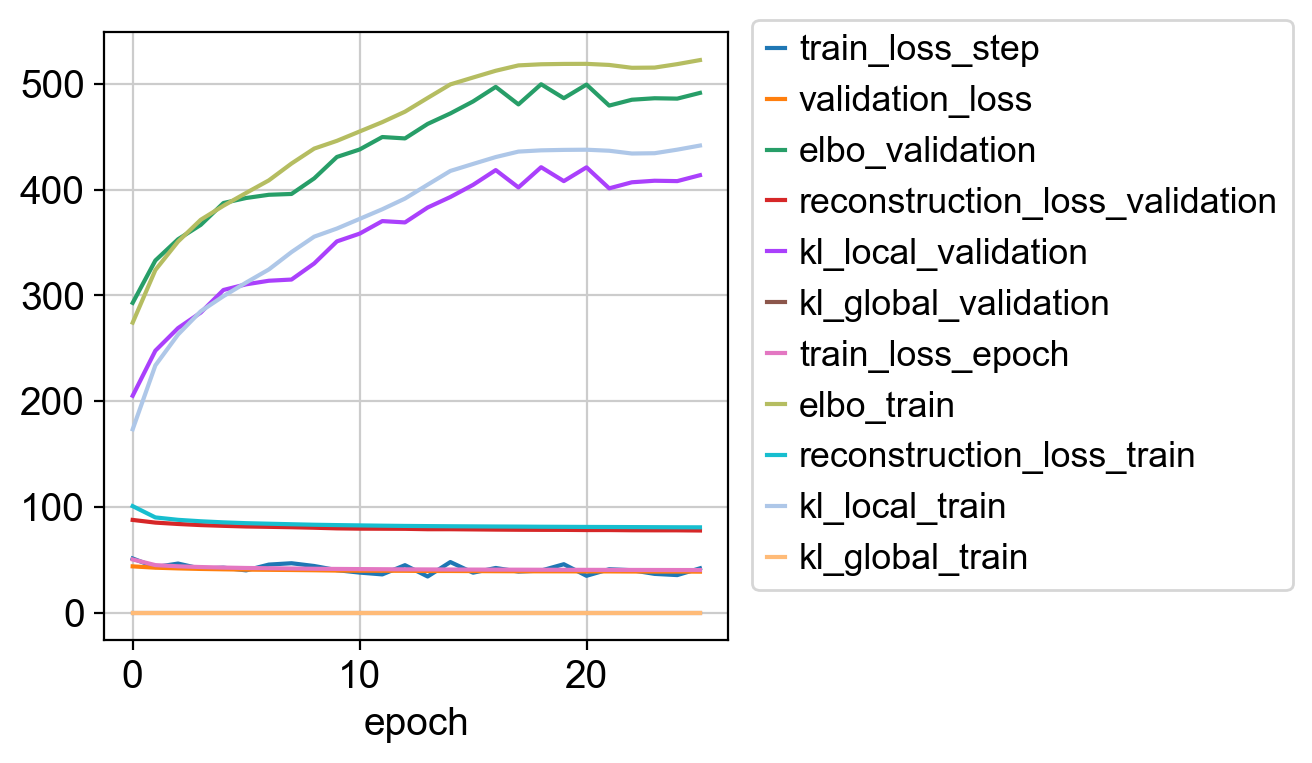

Global seed set to 1
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:39<24:38, 19.98s/it, loss=40.4, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 296.539. Signaling Trainer to stop.


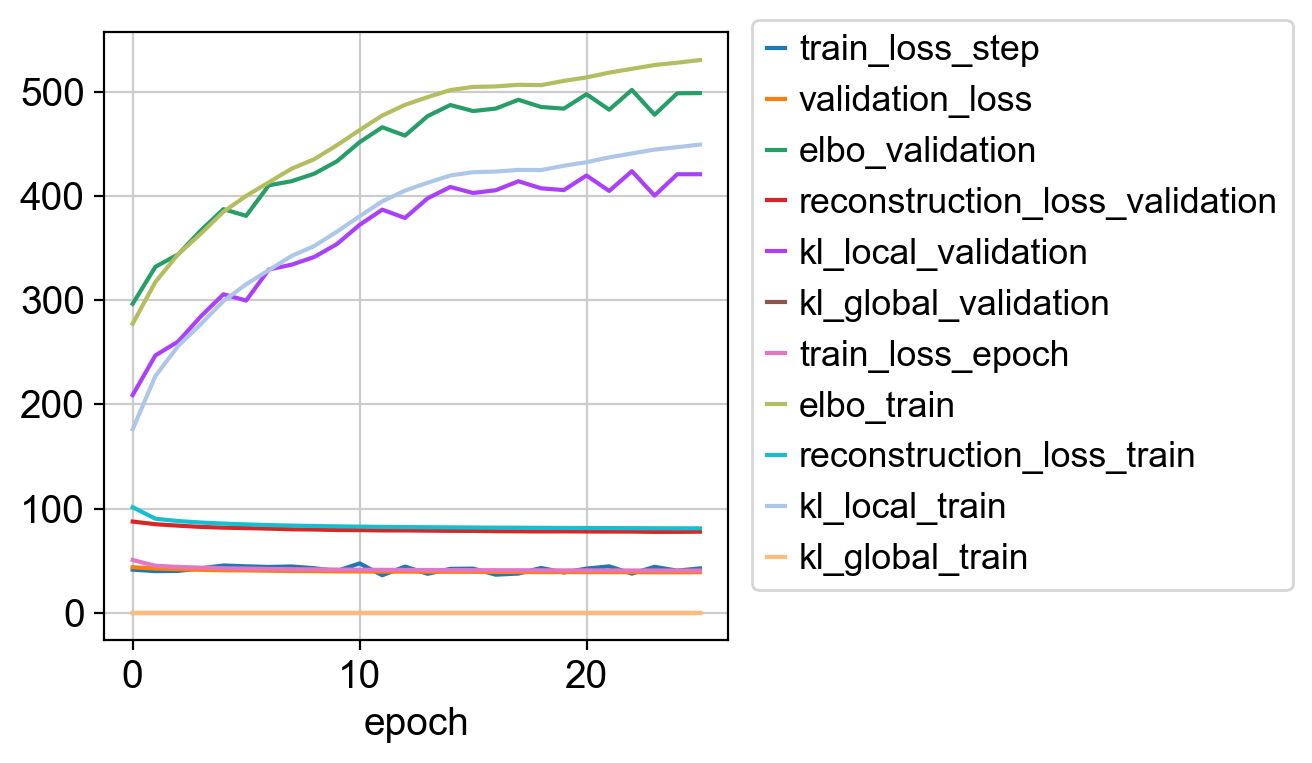

Global seed set to 2
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:26<24:00, 19.46s/it, loss=40.3, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 308.752. Signaling Trainer to stop.


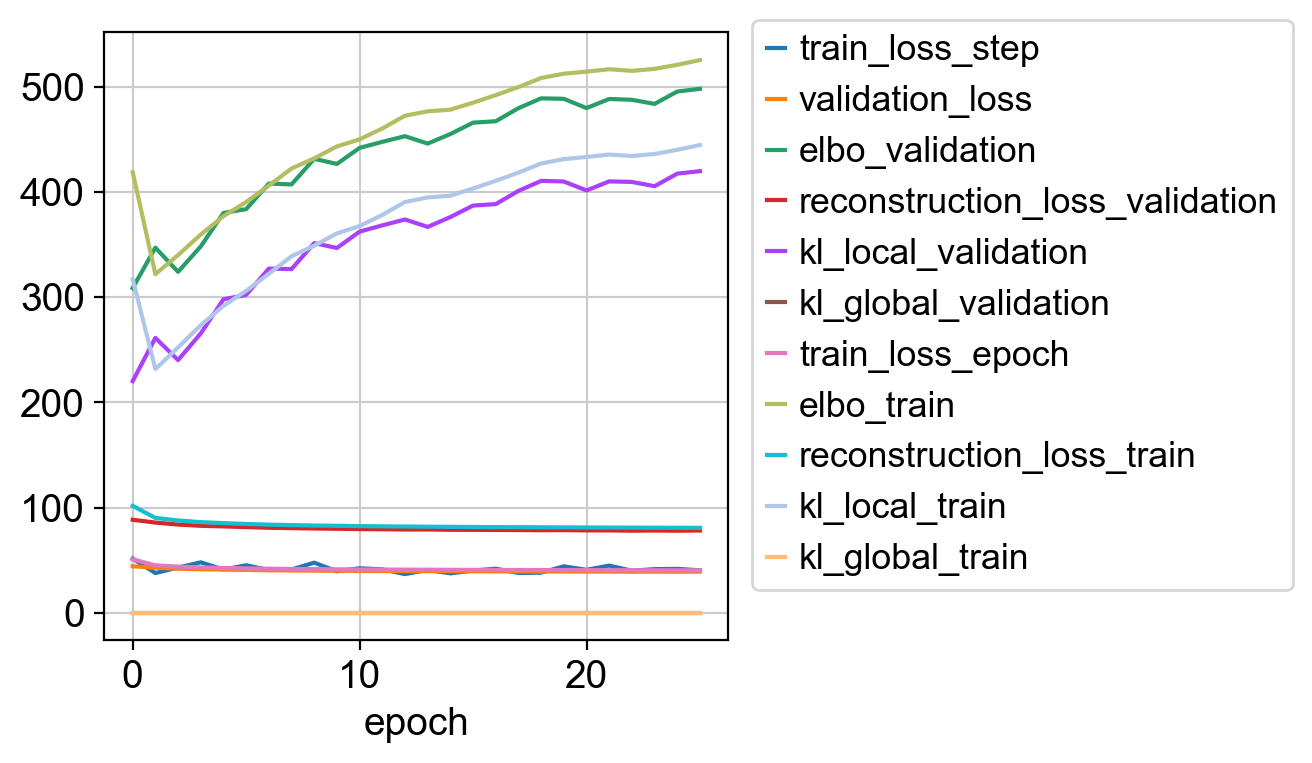

Global seed set to 3
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [09:02<25:42, 20.85s/it, loss=40.9, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 311.741. Signaling Trainer to stop.


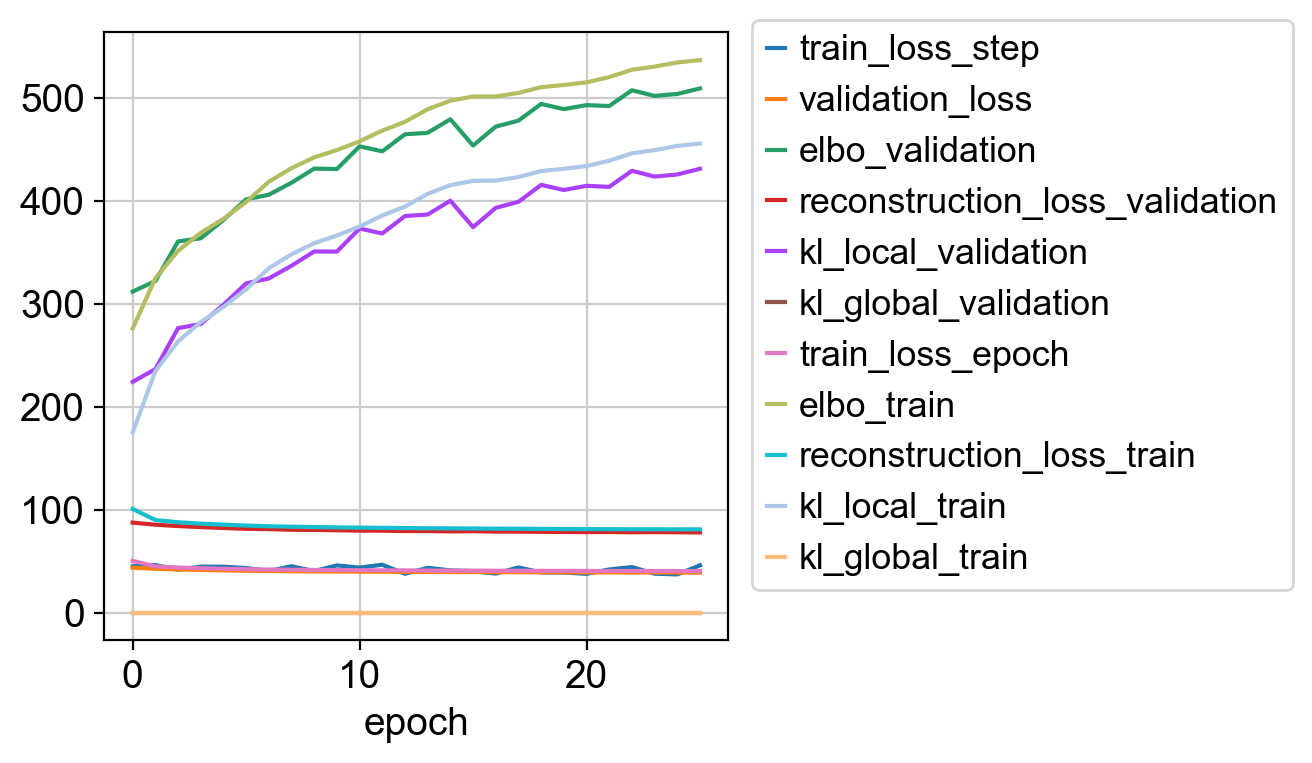

Global seed set to 4
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [07:59<22:44, 18.44s/it, loss=40.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 305.467. Signaling Trainer to stop.


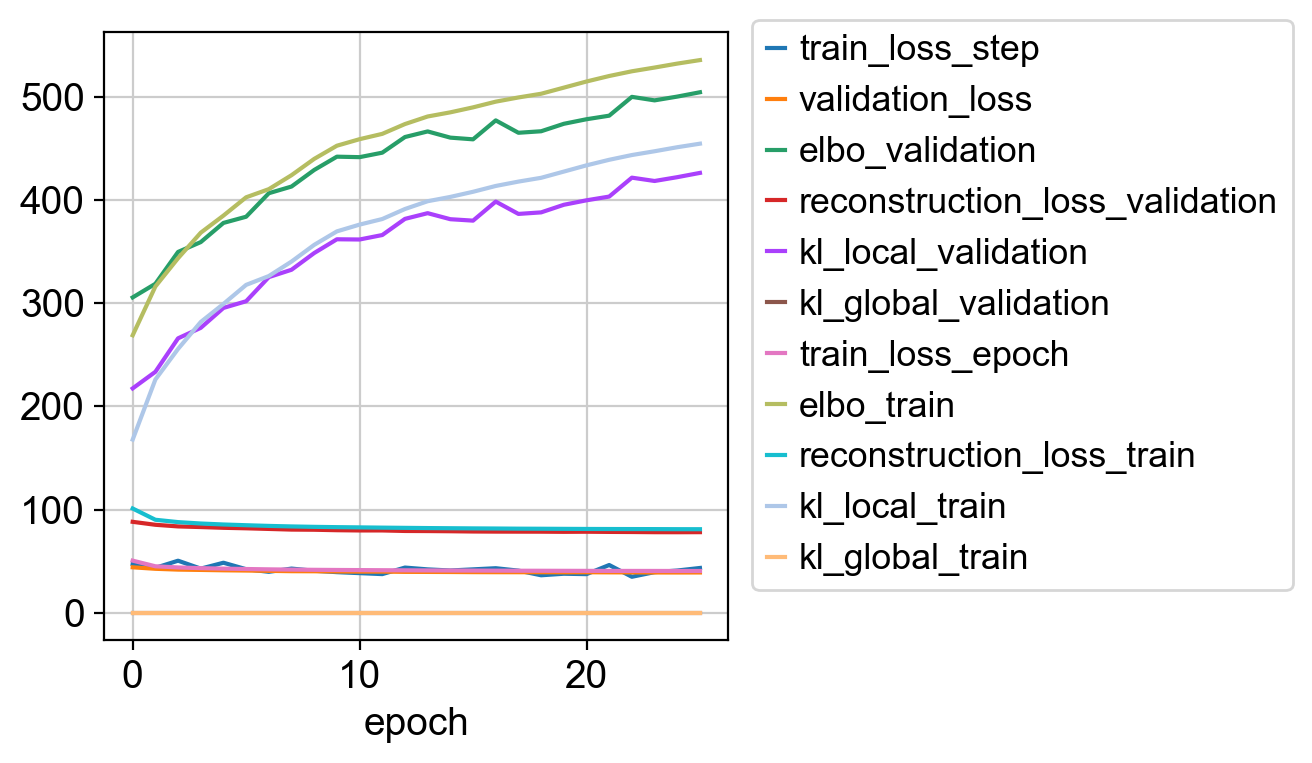

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                def

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:38<24:34, 19.93s/it, loss=41.3, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 299.425. Signaling Trainer to stop.


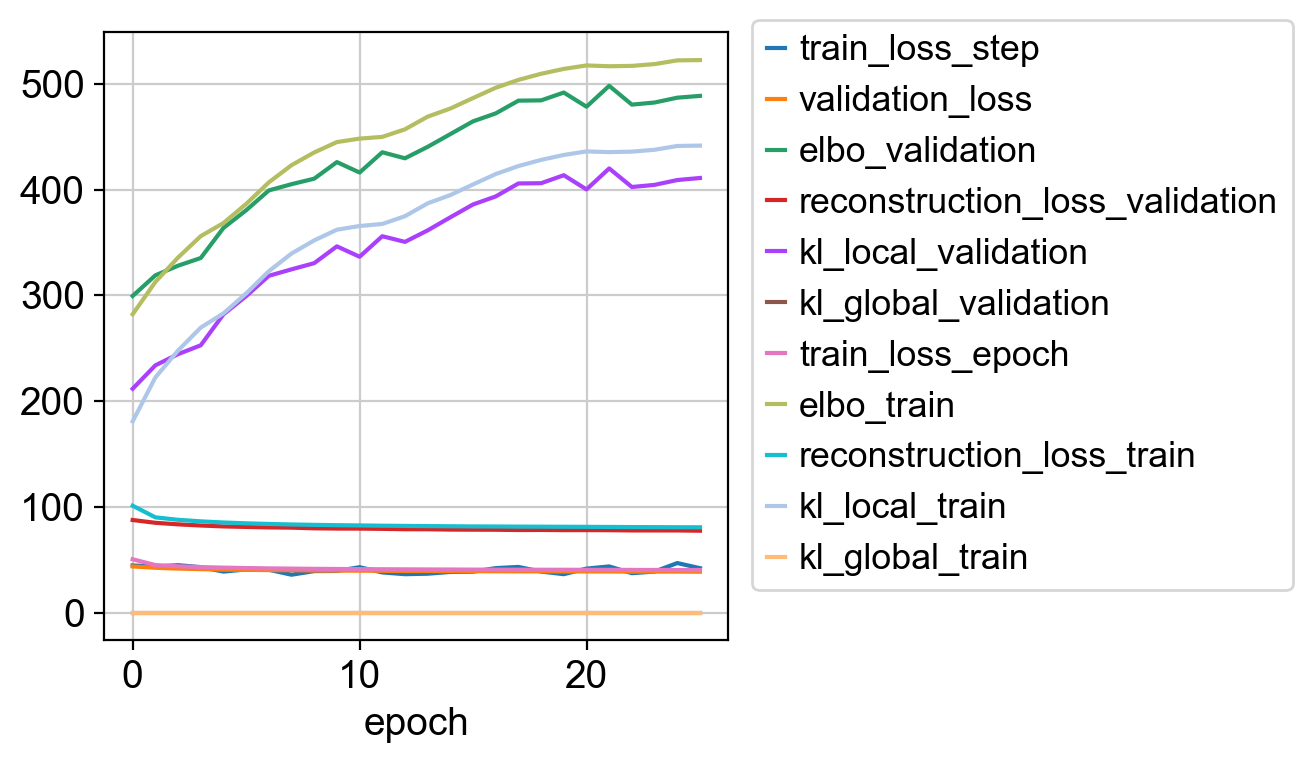

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                def

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [09:01<25:41, 20.84s/it, loss=41.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 306.475. Signaling Trainer to stop.


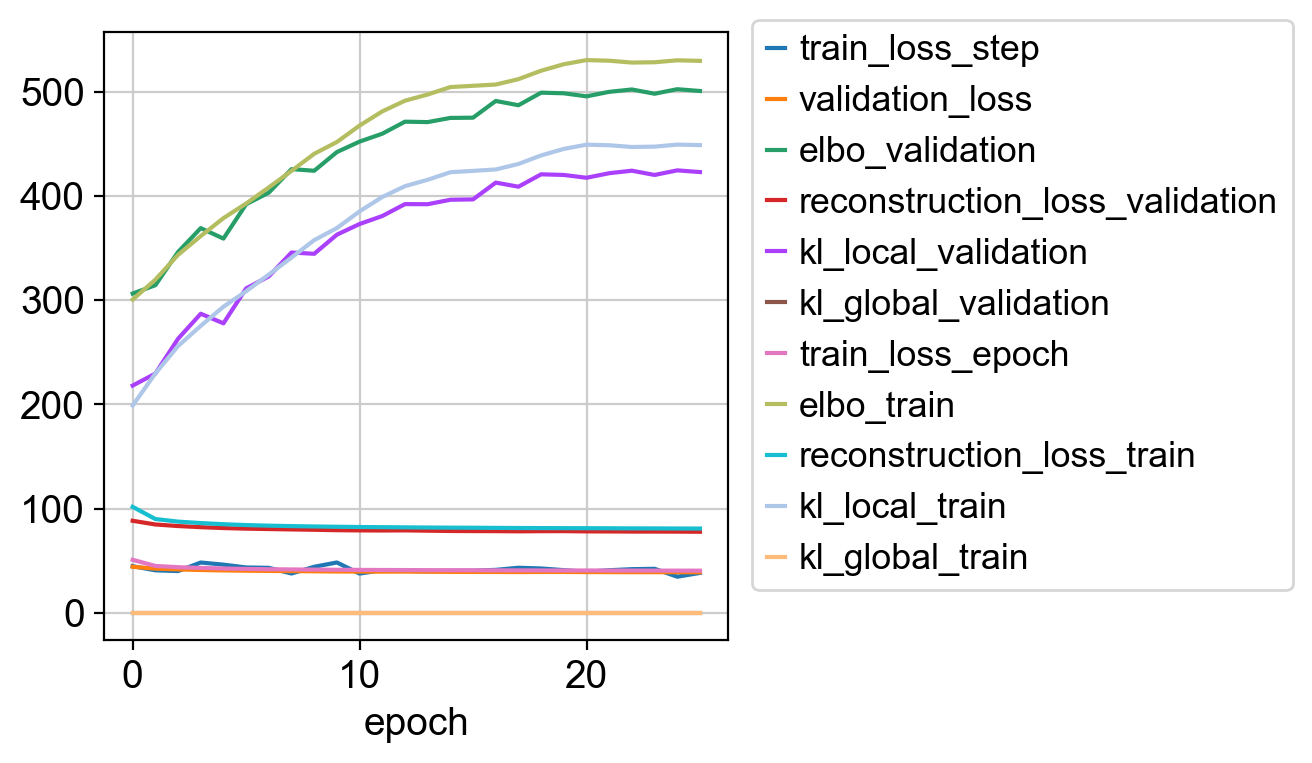

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                def

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:39<24:39, 19.99s/it, loss=40.6, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 279.354. Signaling Trainer to stop.


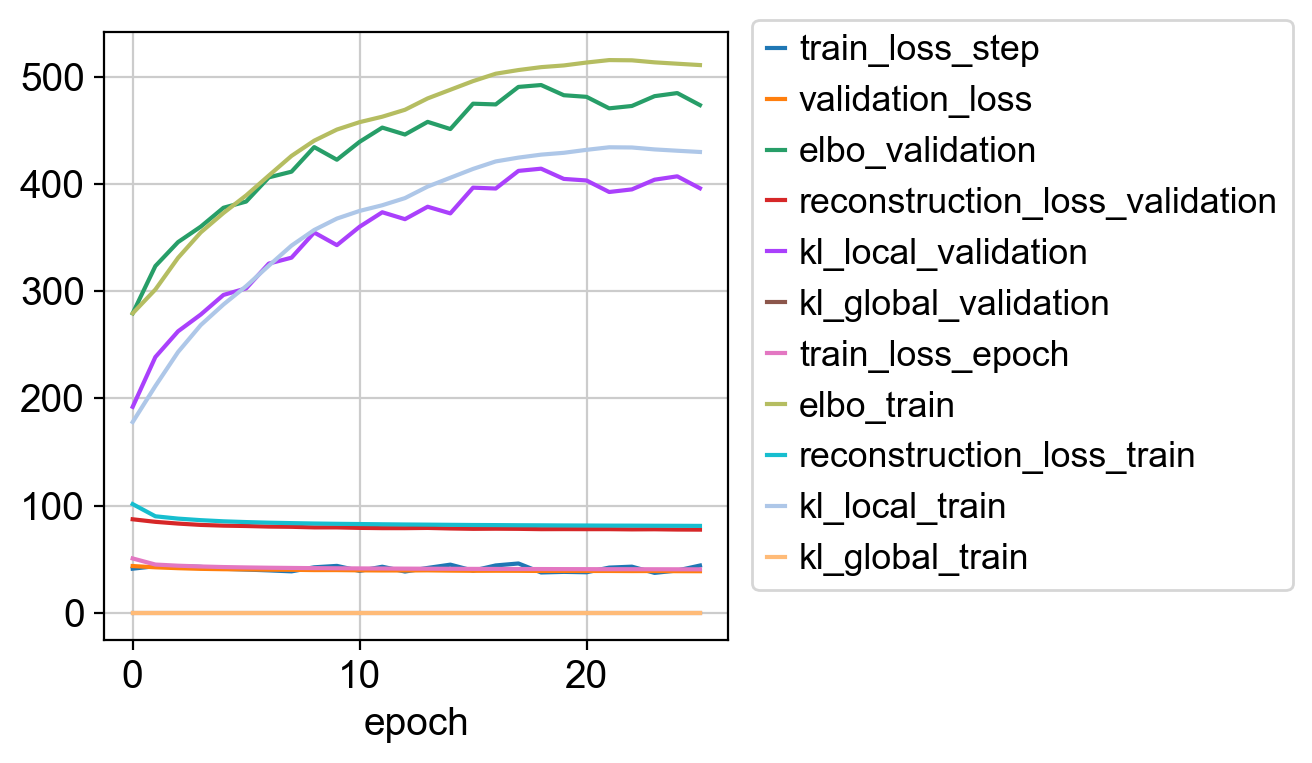

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                def

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:52<25:15, 20.47s/it, loss=41.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 325.620. Signaling Trainer to stop.


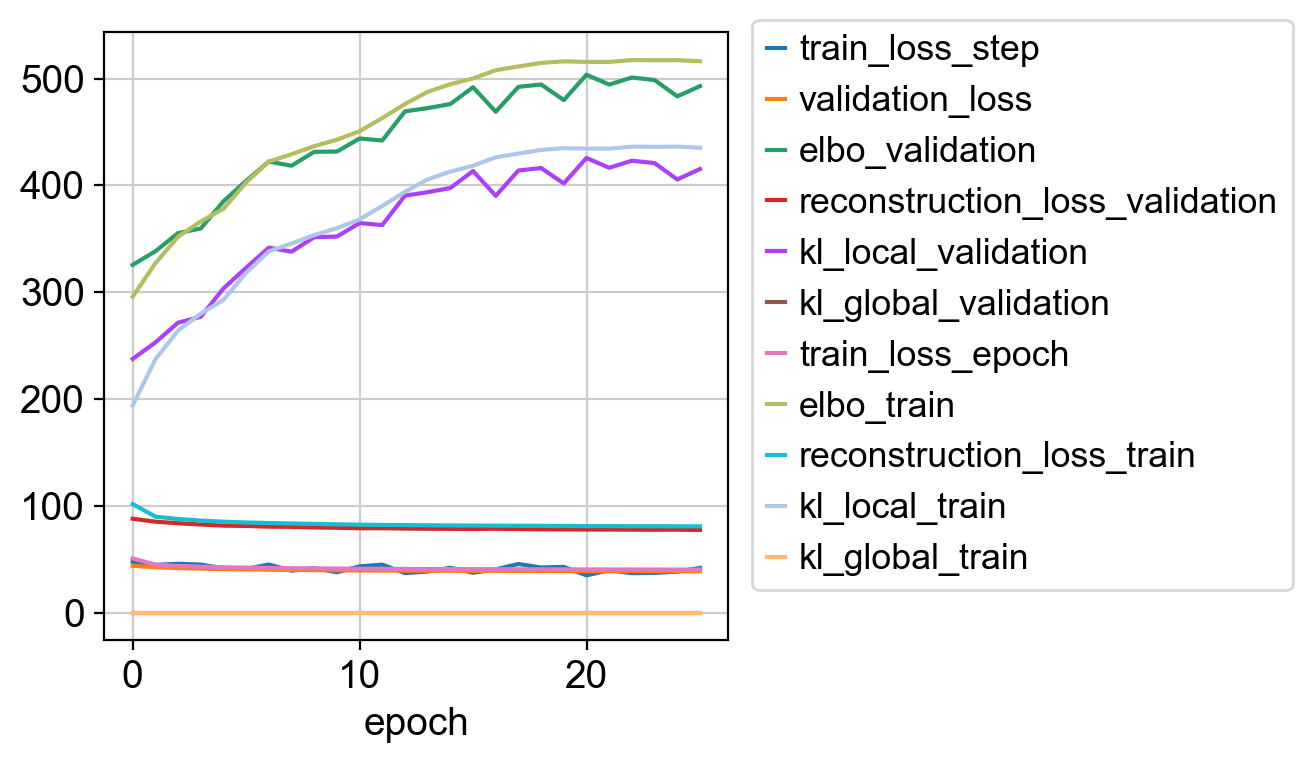

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                def

Epoch 26/100:  26%|██████████████████████████████████████████████▊                                                                                                                                     | 26/100 [08:58<25:32, 20.71s/it, loss=40.3, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 291.707. Signaling Trainer to stop.


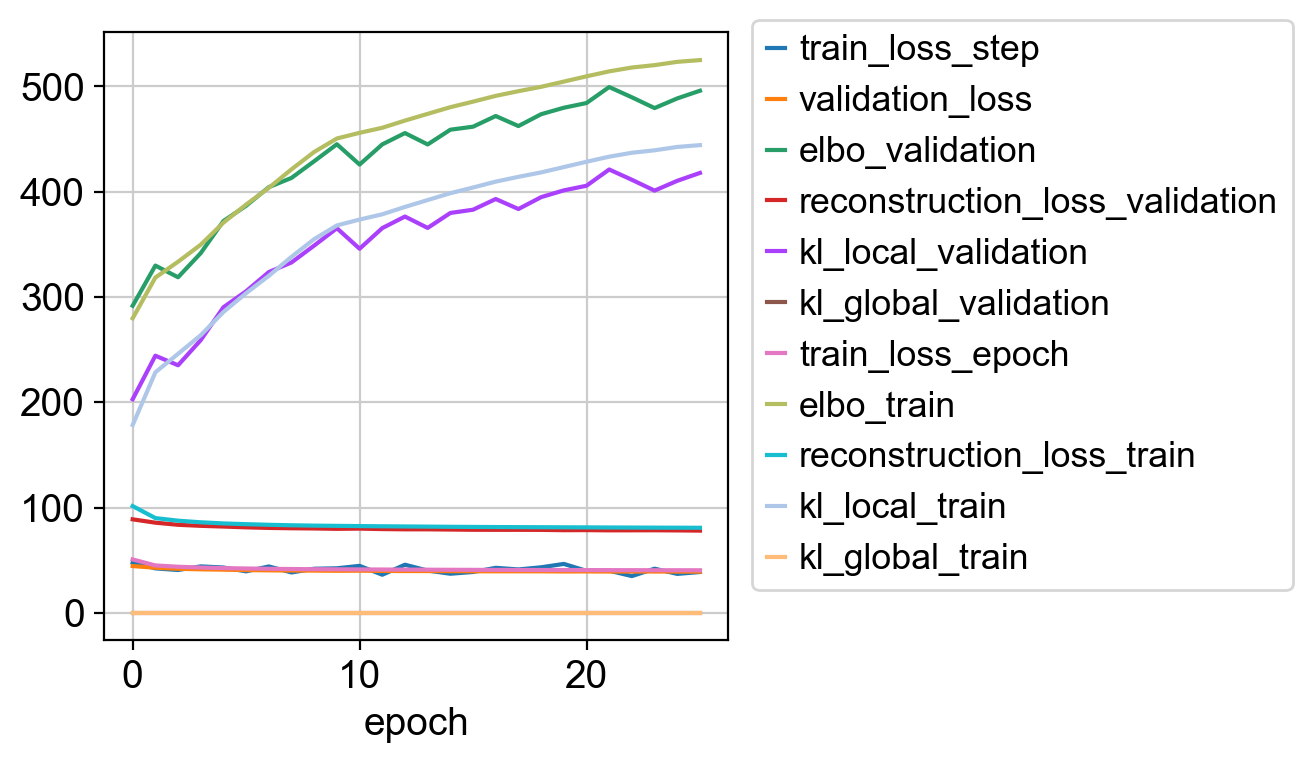

In [37]:
def train_model(data, i, save_model_as):
    model = scgen.SCGEN(data, n_hidden=400, n_latent=30)
    model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=False,
#         early_stopping_patience=25
    )
    model.save(save_model_as, overwrite=True)
    # plot performance
    pd.concat(model.history.values(), axis=1).plot()
    plt.legend(bbox_to_anchor=(1.01, 1.05))
    plt.show()
    return model

n_runs=5
# run with different seeds
for i in range(n_runs):
    scvi.settings.seed = i
    _ = train_model(adata, i, f"../models/scgen_norman19_model{i}_random_v2")

# run with shuffled data
for i in range(n_runs):
    indices = list(range(adata.shape[0]))
    random.Random(i).shuffle(indices)
    adata = adata[indices].copy()
    scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
    _ = train_model(adata, i, f"../models/scgen_norman19_model{i}_shuffled_v2")

TODO: make sure models are truly different

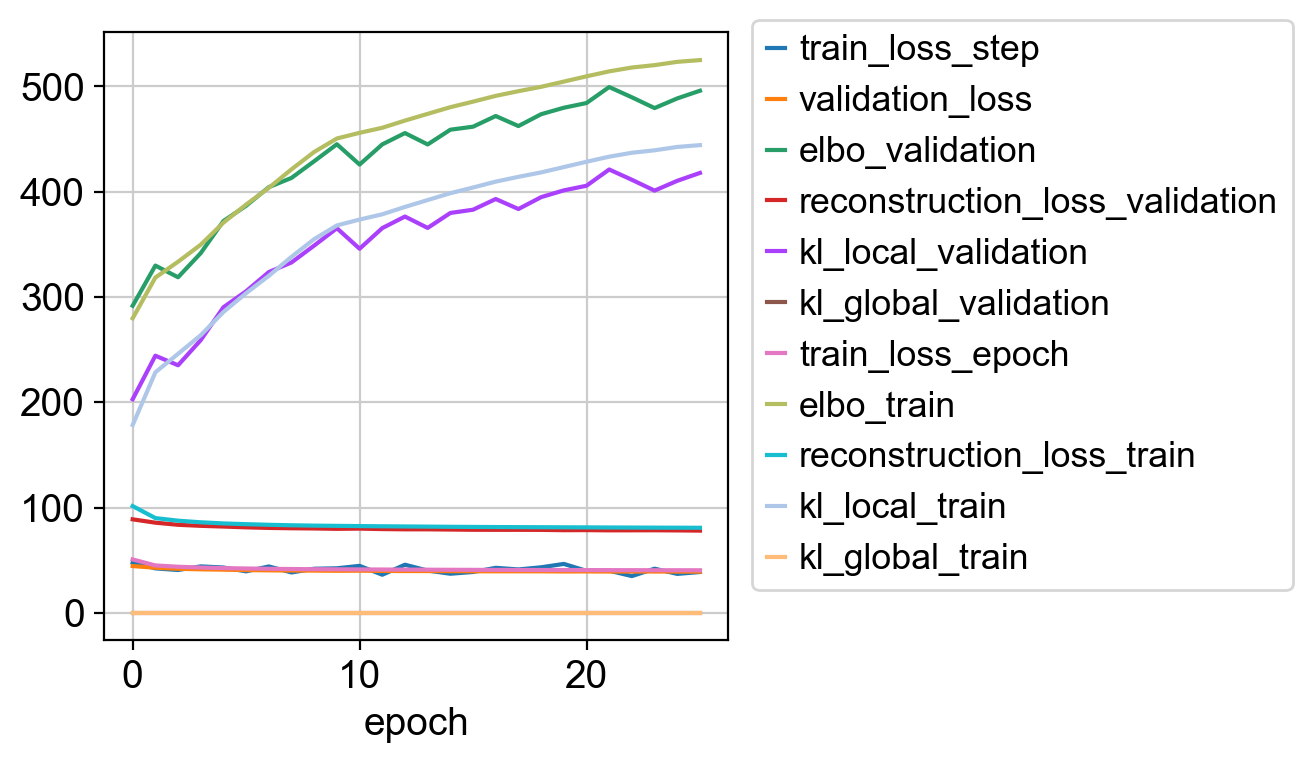

In [39]:
# plot the very last one to check
pd.concat(_.history.values(), axis=1).plot()
plt.legend(bbox_to_anchor=(1.01, 1.05));

## Quality control

potential todo: loop over multiple models here.

In [40]:
# take the last one
model = _

We'll start off with latent space visualization. This should have the same if not more structure than the original UMAP.

In [41]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

In [42]:
latent_adata

AnnData object with n_obs × n_vars = 69570 × 30
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guid

In [43]:
%%time
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

CPU times: user 1min 49s, sys: 9.12 s, total: 1min 58s
Wall time: 1min 33s


In [44]:
adata.obs.perturbation_name.value_counts().head(5)

control    11835
KLF1        1954
BAK1        1451
CEBPE       1230
ETS2        1201
Name: perturbation_name, dtype: int64

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))


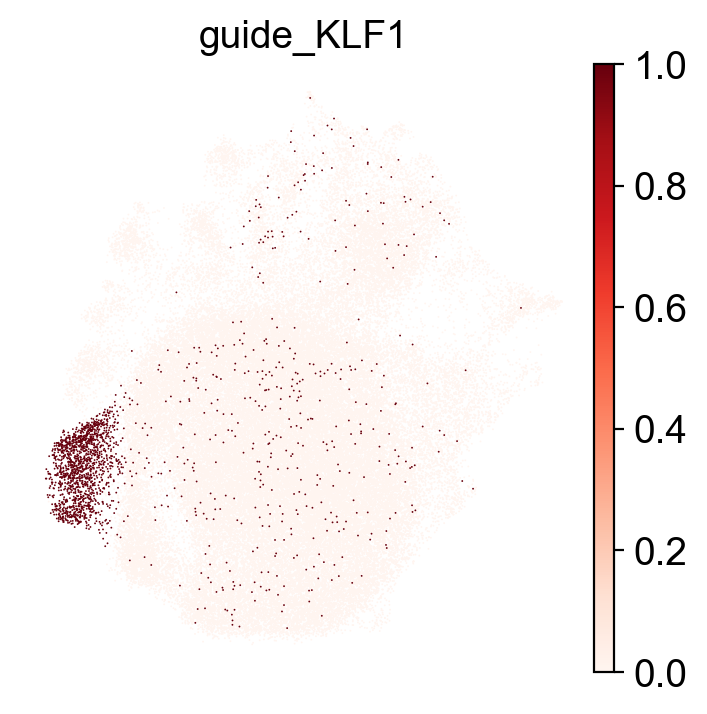

In [45]:
sc.pl.umap(latent_adata, color=['guide_KLF1'], cmap='Reds')

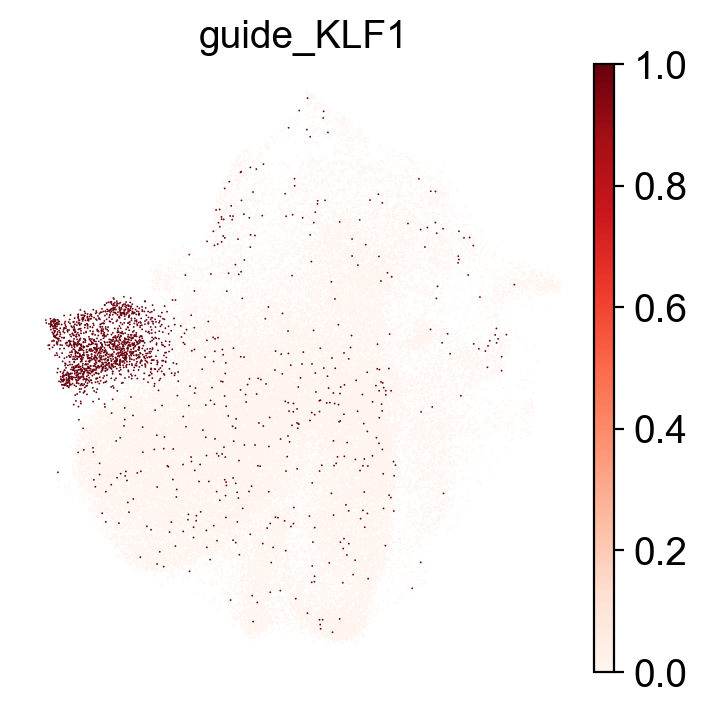

In [46]:
sc.pl.umap(adata, color=['guide_KLF1'], cmap='Reds')

### Mean correlations

(Standard evaluation metrics, but no test set.)

In [47]:
example_pert = 'KLF1'  # condition with the most occurrences

TODO: run the full 30min diffexp when you have time

In [48]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['control', example_pert])]

sc.tl.rank_genes_groups(ctrl_adata, groupby='perturbation_name', reference='control', method='wilcoxon')

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [49]:
diff_genes = ctrl_adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

['TMSB10' 'HBZ' 'PNMT' 'KLF1' 'KLF1' 'HBG2' 'HBA1' 'HBG1' 'EMP3' 'ANXA2']


In [50]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key=example_pert,
    adata_to_predict=adata[adata.obs.perturbation_name == 'control'].copy()  # strange implementation but ok
)
pred.obs['perturbation_name'] = 'pred'

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [60]:
pred.var_names_make_unique()
ctrl_adata.var_names_make_unique()
eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


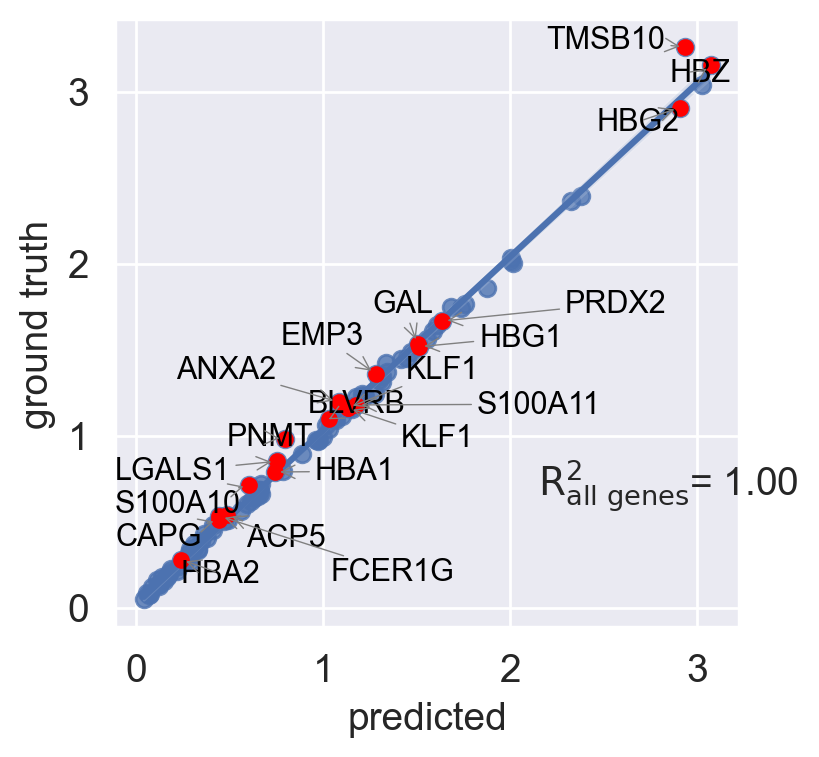

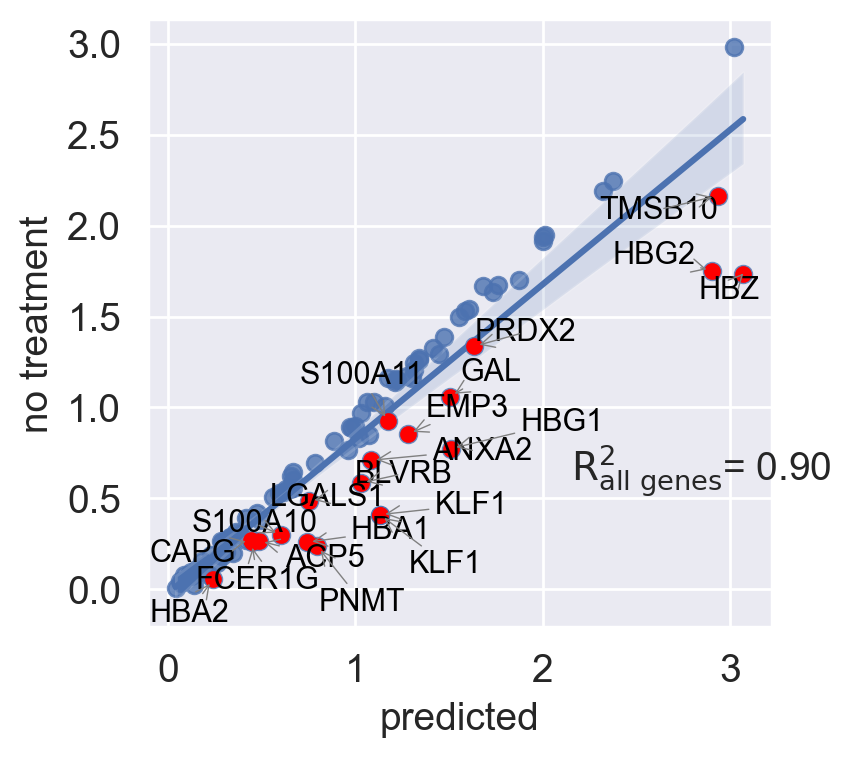

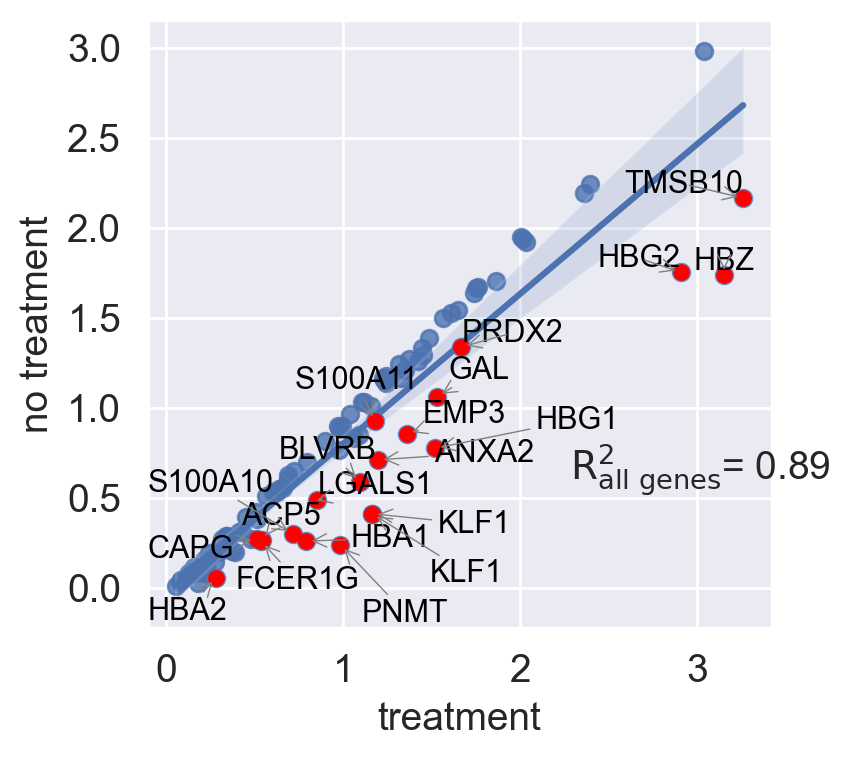

In [62]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': example_pert},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'ground truth'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'no treatment'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': example_pert, 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'treatment', 'y': 'no treatment'},
    show=True,
    legend=False
)

This is exactly the trend in performance we'd expect.

TODO: loop over all conditions to get an overall score

### linear classifier

We'll train a perturbation classifier on the latent vectors produced by the scGen model for perturbed conditions as a proxy for successfully learning separable features. This is additionally valid because scGen performs linear vector arithmetic to infer the perturbation effect.

In [70]:
from sklearn.linear_model import LogisticRegression

In [73]:
%%time
clf = LogisticRegression(solver='saga')
clf.fit(
    latent_adata[latent_adata.obs.split == 'train'].X,
    latent_adata[latent_adata.obs.split == 'train'].obs.perturbation_name.values
)

CPU times: user 2min 30s, sys: 134 ms, total: 2min 30s
Wall time: 2min 31s


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [78]:
print(clf.score(
    latent_adata[latent_adata.obs.split == 'test'].X,
    latent_adata[latent_adata.obs.split == 'test'].obs.perturbation_name.values
))
clf.score(
    latent_adata[latent_adata.obs.split == 'train'].X,
    latent_adata[latent_adata.obs.split == 'train'].obs.perturbation_name.values
)

0.0075


0.3723579586525951

Oh no that's atrocious...

In [79]:
%%time
clf_full = LogisticRegression(solver='saga')
clf_full.fit(
    adata[adata.obs.split == 'train'].X,
    adata[adata.obs.split == 'train'].obs.perturbation_name.values
)

CPU times: user 21min 56s, sys: 959 ms, total: 21min 57s
Wall time: 21min 59s


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [80]:
print(clf_full.score(
    adata[adata.obs.split == 'test'].X,
    adata[adata.obs.split == 'test'].obs.perturbation_name.values
))
clf_full.score(
    adata[adata.obs.split == 'train'].X,
    adata[adata.obs.split == 'train'].obs.perturbation_name.values
)

0.305


0.6876246927858899

In [88]:
import anndata as ad

Test the classifier on reconstructed data.

In [97]:
preds = []
for pert in ['C19orf26', 'KIAA1804', 'C3orf72']:
    pred, delta = model.predict(
        ctrl_key='control',
        stim_key=pert,
        adata_to_predict=adata[adata.obs.perturbation_name == 'control'][:100].copy()  # strange implementation but ok
    )
    pred.var_names_make_unique()
    pred.obs['perturbation_name'] = pert
    preds.append(pred)
pred = ad.concat(preds)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/li

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [99]:
clf_full.score(
    pred.X,
    pred.obs.perturbation_name.values
)

0.0

Holy crap